In [1]:
## imports

import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
# import nc_time_axis

from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import linregress

import mtspec

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors

%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore','SerializationWarning')

In [3]:
from defs import MonthConverter, trim_axs, find_nearest, Nino34_timeseries, Nino_timeseries

In [4]:
figwidth1 = 8.3;
figwidth2 = 12;
labelfontsize = 13;
legendfontsize = 12;
titlefontsize = 13;

## Load observations 

In [5]:
## HadISST data
## https://www.metoffice.gov.uk/hadobs/hadisst/data/download.html
## 1870 - 2020 SST data

file = 'observations/HadISST/HadISST_sst.nc'
ds   = xr.open_dataset(file)

minlat = -5;  maxlat = 5;
minlon = -170; maxlon = -120;
var    = ds.sst; lat = ds.latitude; lon = ds.longitude; 
dimlat = 'latitude'; dimlon = 'longitude'

## calculate nino3.4
Nino34       = var.where(lat>minlat).where(lat<maxlat).where(lon>minlon).where(lon<maxlon).mean(dim=dimlat).mean(dim=dimlon)

# last 100y
Nino34 = Nino34[-1200:]

## take off climatology
nino_hadisst = Nino34.groupby('time.month') - Nino34.groupby('time.month').mean(dim='time')

## linear detrending (to remove 'climate change' trends)
t = range(len(nino_hadisst))
p = np.polyfit(t, nino_hadisst, 1)
l = t*p[0] + p[1]
nino_hadisst = nino_hadisst - l

## 30y running mean er af halen?


Text(0, 0.5, 'Nino3.4 ($^{\\circ}$C)')

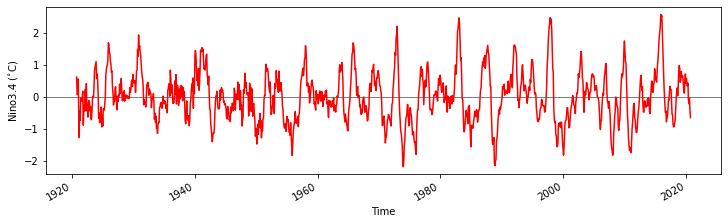

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10,3), constrained_layout=True)

nino_hadisst.plot(ax=ax, color='r')
ax.axhline(y=0, color='k', zorder=-1, linewidth=0.5)
ax.set_ylabel('Nino3.4 ($^{\circ}$C)')

# plt.savefig('figures/HadISST_nino34.png', dpi=200)

In [3]:
## Nino34 data from http://bmcnoldy.rsmas.miami.edu/tropics/oni/
## observations from 1950 - 2020

fh = open('observations/detrend.nino34.ascii.txt')

Nino34_obs = np.array([0.])

read_lines = fh.readlines()
for line in range(1,len(read_lines)):
    nino = np.float(read_lines[line][27:32])
    Nino34_obs = np.concatenate((Nino34_obs, np.array([nino])), axis=0)

Nino34_obs = Nino34_obs[1:]
fh.close()

In [4]:
ERSST_std = 0.69
# Standard Deviation of ERSST Nino3.4 observations, via Brierley 2015

## Load model data

In [6]:
modellist = ['CCSM4', 'CCSM4-UoT', 'CCSM4-Utr', 'CESM1.2', 'CESM2', 'COSMOS', 'EC-Earth3.3',
             'GISS2.1G', 'HadCM3', 'HadGEM3', 'IPSLCM5A', 'IPSLCM5A2', 'IPSLCM6A', 'MIROC4m', 
             'MRI2.3', 'NorESM-L', 'NorESM1-F']

i=4
model=modellist[i]
print('model = ' + model)

run = 'EOI400'
# file = 'models/' + model + '/' + model + '_' + run + '.SST.timeseries_no_ann_cycle.nc'
file = f'models/{model}/{model}_{run}.SST.timeseries_no_ann_cycle.nc'
ds = xr.open_dataset(file)
ds

model = CESM2


<xarray.Dataset>
Dimensions:    (bnds: 2, latitude: 180, longitude: 360, time: 1200)
Coordinates:
  * time       (time) object 1101-02-01 00:00:00 ... 1201-01-01 00:00:00
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
    month      (time) int32 ...
    year       (time) int32 ...
Dimensions without coordinates: bnds
Data variables:
    TS         (time, latitude, longitude) float32 ...
    time_bnds  (time, bnds) object ...
Attributes:
    NCO:               netCDF Operators version 4.7.9 (Homepage = http://nco....
    case:              b.e21.B1850.f09_g17.PMIP4-midPliocene-eoi400.001
    history:           Wed Feb  5 13:58:33 2020: ncrcat b.e21.B1850.f09_g17.P...
    host:              cheyenne6
    initial_file:      b.e21.B1850.f09_g17.PMIP4-pliomip2.001.cam.i.0479-01-0...
    logname:           cmip6
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    source:            CAM
    time_period_freq:  month_1
    topography_file:   /gpfs/fs1/p/cesm/palwg/pliocene/pliomip2_cesm2/bnd/new...
    Conventions:       CF-1.5

## SAT (large scale features paper)

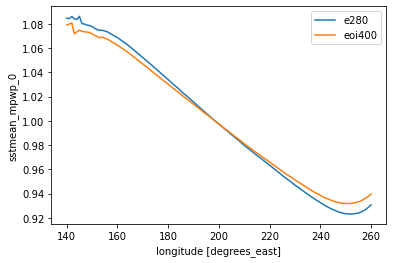

In [467]:
path = 'cp-16-2095-2020-supplement/Supplementary/data_for_fig4.nc'
ds = xr.open_dataset(path)

EPsst_e280 = ds.sstmean_pi_0.where(ds.latitude<5).where(ds.latitude>-5).mean(dim='latitude')
EPsst_eoi400 = ds.sstmean_mpwp_0.where(ds.latitude<5).where(ds.latitude>-5).mean(dim='latitude')

# (ds.sstmean_pi_0.mean(dim='latitude')/ds.sstmean_pi_0.mean()).plot()
# (ds.sstmean_mpwp_0.mean(dim='latitude')/ds.sstmean_mpwp_0.mean()).plot()# - ds.sstmean_pi_0.mean(dim='latitude')).plot()

(EPsst_e280/EPsst_e280.mean()).plot(label='e280')
(EPsst_eoi400/EPsst_eoi400.mean()).plot(label='eoi400')
plt.legend()

In [321]:
## Global mean SAT
## via https://doi.org/10.5194/cp-16-2095-2020
## Haywood 2020 large scale features paper

models_LS = ['CCSM4-Utr', 'CCSM4', 'CCSM4-UoT', 'CESM1.2', 'CESM2', 'COSMOS', 'EC-Earth3.3',
             'GISS2.1G', 'HadCM3', 'IPSLCM6A', 'IPSLCM5A2', 'IPSLCM5A', 'MIROC4m', 'MRI2.3',
             'NorESM-L', 'NorESM1-F']
SAT_LS_E280 = [13.8, 13.4, 13.0, 13.3, 14.1, 13.5, 13.3, 13.8, 14.0, 12.6, 13.2, 12.1, 12.8,
              12.7, 12.5, 14.5]
SAT_LS_EOI400 = [18.5, 16.0, 16.8, 17.3, 19.3, 16.9, 18.2, 15.9, 16.9, 16.0, 15.3, 14.4, 
                15.9, 15.1, 14.6, 16.2]

SAT_e280   = np.zeros(len(modellist));
SAT_eoi400 = np.zeros(len(modellist));

for i in range(len(modellist)):
    for j in range(len(models_LS)):
        if modellist[i] == models_LS[j]:
            SAT_e280[i]   = SAT_LS_E280[j];
            SAT_eoi400[i] = SAT_LS_EOI400[j];


In [275]:
fh = open('models/data_for_1a_1c_3a.txt')

# Nino34_obs = np.array([0.])

modellist_SAT = []
lats_sat = np.zeros(180) #np.array([0.])
zm_sat   = np.zeros((180,16)) #np.array([0.])
skip = False
i=0; j=0

read_lines = fh.readlines()
for line in range(39,len(read_lines)):
    
    if skip==True: 
        skip = False
        
    else:
    
        a = read_lines[line][:-1].split(",")

        if len(a) == 1:
            print(a)
            modellist_SAT = np.concatenate((modellist_SAT, a)) #f'{modellist_SAT},{np.str(a)[1:-1]}'
            j=0
            i = i+1
            skip = True
            
        else:
            if i==1:
                lats_sat[j] = np.float(a[0]) #np.concatenate((lats_sat, np.array([np.float(a[0])])) ,axis=0)
                zm_sat[j,i-1]   = np.float(a[1]) #np.concatenate((zm_sat, np.array([np.float(a[1])])) ,axis=0)
                j=j+1
            else:
                zm_sat[j,i-1]   = np.float(a[1])
                j=j+1
        
    
#     a[line] = read_lines[line][0:-1]
#     nino = np.float(read_lines[line][27:32])
#     Nino34_obs = np.concatenate((Nino34_obs, np.array([nino])), axis=0)
#     a = read_lines

# Nino34_obs = Nino34_obs[1:]
fh.close()

modellist_SAT = modellist_SAT[:-1]
# lats_sat = lats_sat[1:]
# zm_sat = zm_sat[1:]

modellist_SAT

['CESM2']
['IPSLCM6A']
['COSMOS']
['EC-Earth3.3']
['CESM1.2']
['IPSLCM5A']
['MIROC4m']
['IPSLCM5A2']
['HadCM3']
['GISS2.1G']
['CCSM4']
['CCSM4-Utr']
['CCSM4-UoT']
['NorESM-L']
['MRI2.3']
['NorESM1-F']
['']


array(['CESM2', 'IPSLCM6A', 'COSMOS', 'EC-Earth3.3', 'CESM1.2',
       'IPSLCM5A', 'MIROC4m', 'IPSLCM5A2', 'HadCM3', 'GISS2.1G', 'CCSM4',
       'CCSM4-Utr', 'CCSM4-UoT', 'NorESM-L', 'MRI2.3', 'NorESM1-F'],
      dtype='<U32')

In [380]:
EP_grad = np.zeros(len(modellist_SAT))

for j in range(len(modellist_SAT)):

    P = 0; E = 0;
    ip = 0; ie = 0; 

    for i in range(len(lats_sat)):
        if (lats_sat[i] < -66) or (lats_sat[i] > 66):
            P = P + zm_sat[i,j]*np.cos(lats_sat[i]);
            ip = ip + np.cos(lats_sat[i])
        elif (lats_sat[i] > -23) and (lats_sat[i] < 23):
            E = E + zm_sat[i,j]*np.cos(lats_sat[i])
            ie = ie + np.cos(lats_sat[i])

    P = P/ip
    E = E/ie

    EP_grad[j] = P - E

## neem oppervlakte verschillen mee tussen poolgebied en equator (cos...)
    

In [381]:
SAT_E2Pgrad = np.zeros(len(modellist));

for i in range(len(modellist)):
    for j in range(len(modellist_SAT)):
        if modellist[i] == models_LS[j]:
            SAT_E2Pgrad[i] = EP_grad[j];

## Calculate NINO3.4, std dev, kurtosis, skew

In [7]:
## Calculate Nino34 index time series 

trend_type = "linear" # linear detrending of Nino34 series
nino_type = 'Nino34'

for i in range(0, len(modellist)):
    
    print('model = ' + modellist[i])
    
#     ds = Nino34_timeseries(model = modellist[i], run='E280', trend = trend_type)
    ds = Nino_timeseries(model = modellist[i], run='E280', mode = nino_type, trend = trend_type)

    if i==0: 
        nino_e280   = np.zeros((len(ds), len(modellist)))    
        nino_eoi400 = np.zeros((len(ds), len(modellist))) 
        
    nino_e280[:,i]   = ds
#     nino_eoi400[:,i] = Nino34_timeseries(model = modellist[i], run='EOI400', trend = trend_type)
    nino_eoi400[:,i] = Nino_timeseries(model = modellist[i], run='EOI400', mode = nino_type, trend = trend_type)



model = CCSM4
model = CCSM4-UoT
model = CCSM4-Utr


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


model = CESM1.2
model = CESM2
model = COSMOS


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy

model = EC-Earth3.3


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy

model = GISS2.1G
model = HadCM3
model = HadGEM3
model = IPSLCM5A
model = IPSLCM5A2
model = IPSLCM6A


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


model = MIROC4m
model = MRI2.3
model = NorESM-L
model = NorESM1-F


# **Appendix Figure 1**

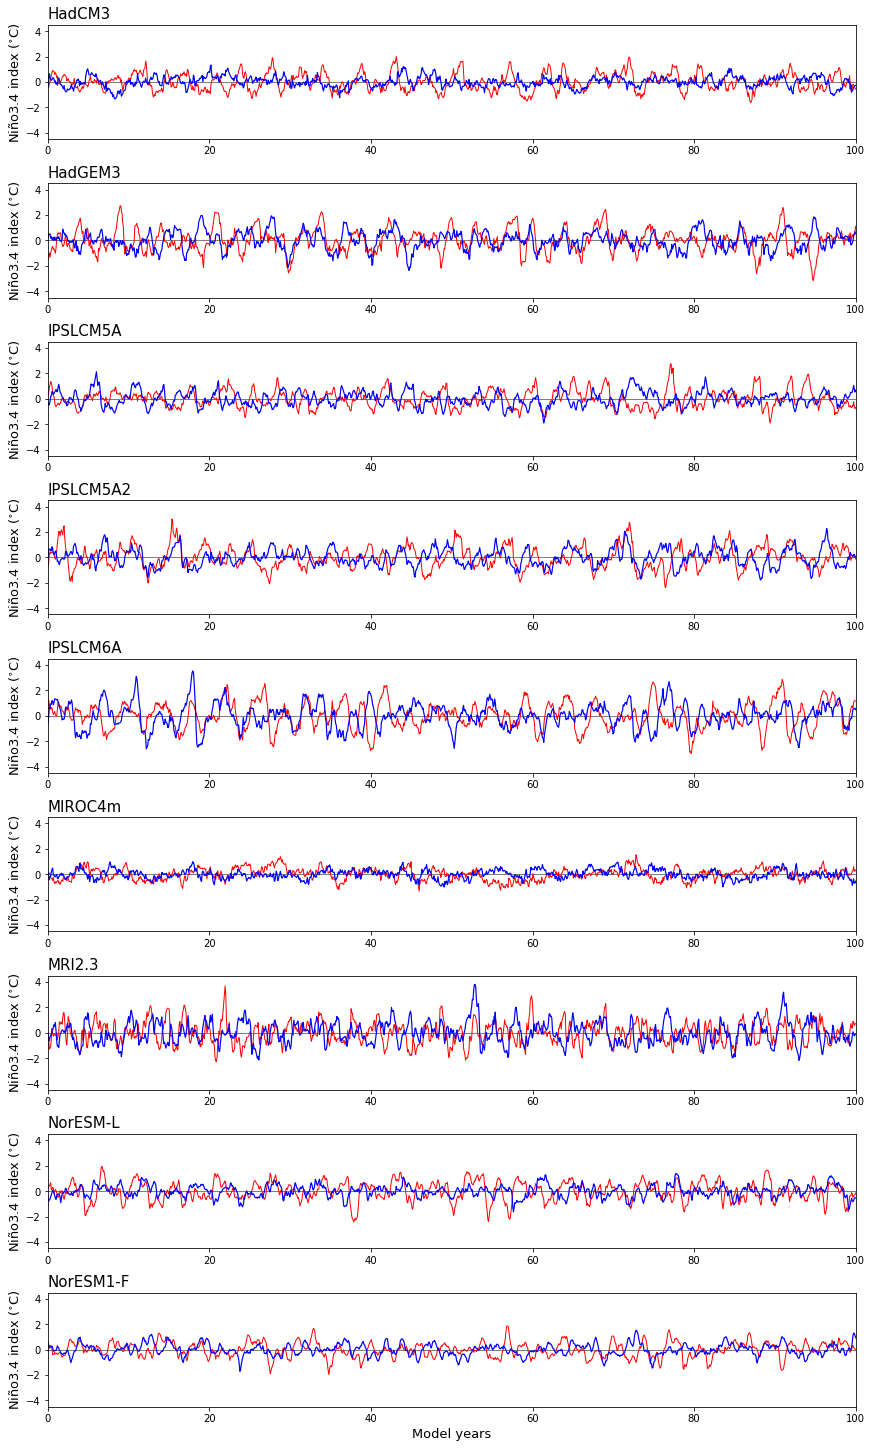

In [32]:
figtype = 'last9'

if figtype == 'all':
    N_models = len(modellist);    
    skip = 0;
    figlen = 40;
elif figtype == 'first8':
    N_models = 9;
    skip = -1;
    figlen = 20;
elif figtype == 'last9':
    N_models = 9;
    skip = 8;
    figlen = 20;

fig1, axs = plt.subplots(nrows = N_models, ncols=1, figsize=(figwidth2, figlen), constrained_layout=True)
# axs = trim_axs(axs, 2*N_models)

# fig1, axs = plt.subplots(nrows=9, ncols=2, figsize=(figwidth2, 20), constrained_layout=True)
# axs = trim_axs(axs, len(modellist))

maxyrs = 100

# for ax, i in zip(axs, range(0,len(modellist))):
for i in range(N_models):
    
    ax=axs[i]

    i_model = i + skip;
    if figtype=='first8' and i==0:
        ax.plot(np.linspace(100-maxyrs, 100, 12*maxyrs), nino_hadisst[-12*maxyrs:], 'k-', linewidth = 1, alpha = 1., label = 'HadISST')
    else:
        ax.plot(np.linspace(100-maxyrs, 100, 12*maxyrs), nino_e280[-12*maxyrs:,i_model], 'r-', linewidth = 1, label='E280')
        ax.plot(np.linspace(100-maxyrs, 100, 12*maxyrs), nino_eoi400[-12*maxyrs:,i_model], 'b-', linewidth = 1.2, label='Eoi400')
    
    ax.set_xlim([100-maxyrs, 100])
    if modellist[i_model]=='COSMOS':
        ax.set_ylim([-6.5, 6.5])
    else:
        ax.set_ylim([-4.5, 4.5])
    ax.plot([100-maxyrs, 100],[0,0],'k-', zorder=-1, linewidth=0.5)
    
    if i==N_models-1:
        ax.set_xlabel('Model years', fontsize=labelfontsize)
    ax.set_ylabel('Niño3.4 index ($^{\circ}$C)', fontsize=labelfontsize)
     
    if figtype=='first8' and i==1:
        ax.legend(loc='upper left')

    if figtype=='first8' and i==0:
        ax.set_title('HadISST 1920-2020', loc='left', fontsize=15)
    else:
        ax.set_title(modellist[i_model], loc='left', fontsize=15)

# plt.savefig('figures/Nino34_timeseries.eps', bbox_inches='tight', dpi=100)
# plt.savefig('figures/appendixfigure1b.pdf', bbox_inches='tight')

In [29]:
std_e280    = np.zeros(len(modellist))
std_eoi400  = np.zeros(len(modellist))
skew_e280   = np.zeros(len(modellist))
skew_eoi400 = np.zeros(len(modellist))
kurt_e280   = np.zeros(len(modellist))
kurt_eoi400 = np.zeros(len(modellist))

for i in range(len(modellist)):
    print(f'model = {modellist[i]}')
    std_e280[i]    = np.std(nino_e280[:,i])
    std_eoi400[i]  = np.std(nino_eoi400[:,i])
    skew_e280[i]   = skew(nino_e280[:,i])
    skew_eoi400[i] = skew(nino_eoi400[:,i])
    kurt_e280[i]   = kurtosis(nino_e280[:,i])
    kurt_eoi400[i] = kurtosis(nino_eoi400[:,i])
        

model = CCSM4
model = CCSM4-UoT
model = CCSM4-Utr
model = CESM1.2
model = CESM2
model = COSMOS
model = EC-Earth3.3
model = GISS2.1G
model = HadCM3
model = HadGEM3
model = IPSLCM5A
model = IPSLCM5A2
model = IPSLCM6A
model = MIROC4m
model = MRI2.3
model = NorESM-L
model = NorESM1-F


In [20]:
i = 4;
print(modellist[i])
100*(std_eoi400[i] - std_e280[i])/std_e280[i]


CESM2


-8.659548456224437

Text(0, 0.5, 'Pliocene Nino3.4 s.d. [$^{\\circ}$C]')

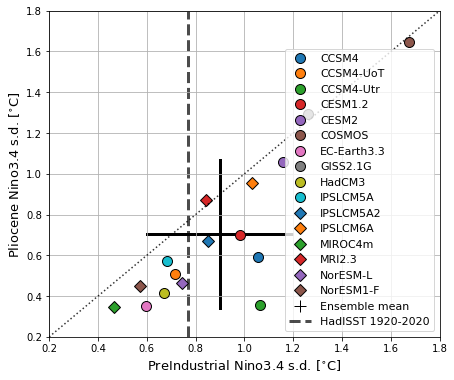

In [9]:
mean_std_e280   = np.mean(std_e280);
mean_std_eoi400 = np.mean(std_eoi400);
std_std_e280    = np.std(std_e280)
std_std_eoi400  = np.std(std_eoi400)

xmin = 0.2; xmax = 1.8;

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(7,6))
for i in range(len(modellist)):
    if i<10: ax.plot(std_e280[i], std_eoi400[i], 'o', label = modellist[i], markersize = 10, markeredgecolor = 'k');
    else:    ax.plot(std_e280[i], std_eoi400[i], 'D', label = modellist[i], markersize = 9, markeredgecolor = 'k');
        
ax.plot(mean_std_e280, mean_std_eoi400, 'k+', markersize = 12, label = 'Ensemble mean', zorder=-1)    
ax.plot([mean_std_e280 - std_std_e280, mean_std_e280 + std_std_e280], [mean_std_eoi400, mean_std_eoi400], 
        'k-', zorder=-1, linewidth=3)
ax.plot([mean_std_e280, mean_std_e280], [mean_std_eoi400 - std_std_eoi400, mean_std_eoi400 + std_std_eoi400], 
        'k-', zorder=-1, linewidth=3)

ax.plot([xmin, xmax],[xmin, xmax],'k:', alpha=0.8);
ax.plot([np.std(nino_hadisst), np.std(nino_hadisst)], [xmin,xmax], 'k--', linewidth=3, alpha=0.7, zorder=-1, label = 'HadISST 1920-2020')
# ax.plot([ERSST_std, ERSST_std], [xmin, xmax], 'b--', alpha=.7, linewidth =3, label = 'NOAA 1850-2005', zorder =-1)
# ax.plot([np.std(Nino34_obs), np.std(Nino34_obs)], [xmin, xmax], 'g--', alpha=.7, linewidth =3, label = 'NOAA 1950-2020', zorder =-1)

ax.legend(fontsize=11)
ax.set_xlim([xmin, xmax]); ax.set_ylim([xmin, xmax])
ax.grid();

ax.set_xlabel(r'PreIndustrial Nino3.4 s.d. [$^{\circ}$C]', fontsize=13)
ax.set_ylabel(r'Pliocene Nino3.4 s.d. [$^{\circ}$C]', fontsize=13)

# plt.savefig('Nino34StdDevScatter_v3.png', bbox_inches='tight', dpi=100)

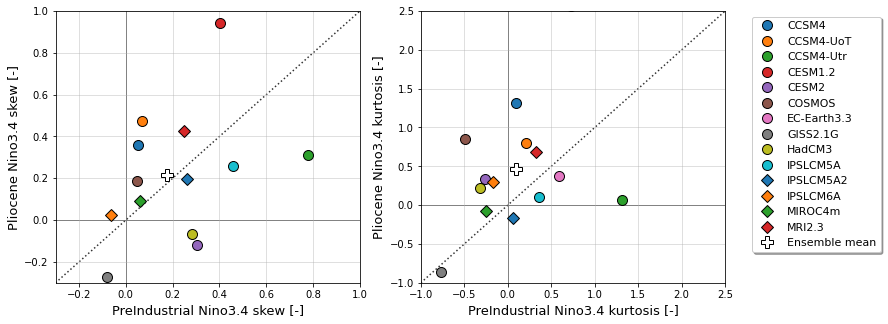

In [31]:
# mean_std_e280   = np.mean(std_e280);
# mean_std_eoi400 = np.mean(std_eoi400);
# std_std_e280    = np.std(std_e280)
# std_std_eoi400  = np.std(std_eoi400)

fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(12,5))

p = 0;

xmin = -0.3; xmax = 1.0;

for i in range(len(modellist)):
    if i<10: ax[p].plot(skew_e280[i], skew_eoi400[i], 'o', label = modellist[i], markersize = 10, markeredgecolor = 'k');
    else:    ax[p].plot(skew_e280[i], skew_eoi400[i], 'D', label = modellist[i], markersize = 9, markeredgecolor = 'k');
        
ax[p].plot(np.mean(skew_e280), np.mean(skew_eoi400),  'P', label='Ensemble mean', markerfacecolor='w', markeredgecolor='k',markersize=12)   
# ax.plot([mean_std_e280 - std_std_e280, mean_std_e280 + std_std_e280], [mean_std_eoi400, mean_std_eoi400], 
#         'r-', zorder=-1, linewidth=3)
# ax.plot([mean_std_e280, mean_std_e280], [mean_std_eoi400 - std_std_eoi400, mean_std_eoi400 + std_std_eoi400], 
#         'r-', zorder=-1, linewidth=3)

ax[p].plot([xmin, xmax],[xmin, xmax],'k:', zorder=-1, alpha=0.8);
ax[p].plot([xmin, xmax], [0,0], 'k-', alpha=0.6, zorder=-1, linewidth=1)
ax[p].plot([0,0], [xmin, xmax], 'k-', alpha=0.6, zorder=-1, linewidth=1)
# ax.plot([ERSST_std, ERSST_std], [xmin, xmax], 'b--', alpha=.7, linewidth =3, label = 'NOAA 1850-2005', zorder =-1)
# ax.plot([np.std(Nino34_obs), np.std(Nino34_obs)], [xmin, xmax], 'g--', alpha=.7, linewidth =3, label = 'NOAA 1950-2020', zorder =-1)

# ax[p].legend(fontsize=11)
ax[p].set_xlim([xmin, xmax]); ax[p].set_ylim([xmin, xmax])
ax[p].grid(alpha=0.5);

ax[p].set_xlabel(r'PreIndustrial Nino3.4 skew [-]', fontsize=13)
ax[p].set_ylabel(r'Pliocene Nino3.4 skew [-]', fontsize=13)


p = 1;

xmin = -1; xmax = 2.5;

for i in range(len(modellist)):
    if i<10: ax[p].plot(kurt_e280[i], kurt_eoi400[i], 'o', label = modellist[i], markersize = 10, markeredgecolor = 'k');
    else:    ax[p].plot(kurt_e280[i], kurt_eoi400[i], 'D', label = modellist[i], markersize = 9, markeredgecolor = 'k');
        
ax[p].plot(np.mean(kurt_e280), np.mean(kurt_eoi400),  'P', label='Ensemble mean', markerfacecolor='w', markeredgecolor='k',markersize=12)    
# ax.plot([mean_std_e280 - std_std_e280, mean_std_e280 + std_std_e280], [mean_std_eoi400, mean_std_eoi400], 
#         'r-', zorder=-1, linewidth=3)
# ax.plot([mean_std_e280, mean_std_e280], [mean_std_eoi400 - std_std_eoi400, mean_std_eoi400 + std_std_eoi400], 
#         'r-', zorder=-1, linewidth=3)

ax[p].plot([xmin, xmax],[xmin, xmax],'k:', zorder=-1, alpha=0.8);
ax[p].plot([xmin, xmax], [0,0], 'k-', alpha=0.6, zorder=-1, linewidth=1)
ax[p].plot([0,0], [xmin, xmax], 'k-', alpha=0.6, zorder=-1, linewidth=1)
# ax.plot([ERSST_std, ERSST_std], [xmin, xmax], 'b--', alpha=.7, linewidth =3, label = 'NOAA 1850-2005', zorder =-1)
# ax.plot([np.std(Nino34_obs), np.std(Nino34_obs)], [xmin, xmax], 'g--', alpha=.7, linewidth =3, label = 'NOAA 1950-2020', zorder =-1)

ax[p].legend(fontsize=11)
ax[p].set_xlim([xmin, xmax]); ax[p].set_ylim([xmin, xmax])
ax[p].grid(alpha=0.5);

ax[p].set_xlabel(r'PreIndustrial Nino3.4 kurtosis [-]', fontsize=13)
ax[p].set_ylabel(r'Pliocene Nino3.4 kurtosis [-]', fontsize=13)

chartBox = ax[p].get_position()
ax[p].set_position([chartBox.x0, chartBox.y0, chartBox.width*1, chartBox.height])
ax[p].legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1, fontsize=11)

# plt.savefig('figures/Nino34_skew_kurtosis.png', bbox_inches='tight', dpi=100)

# **Figure 2**

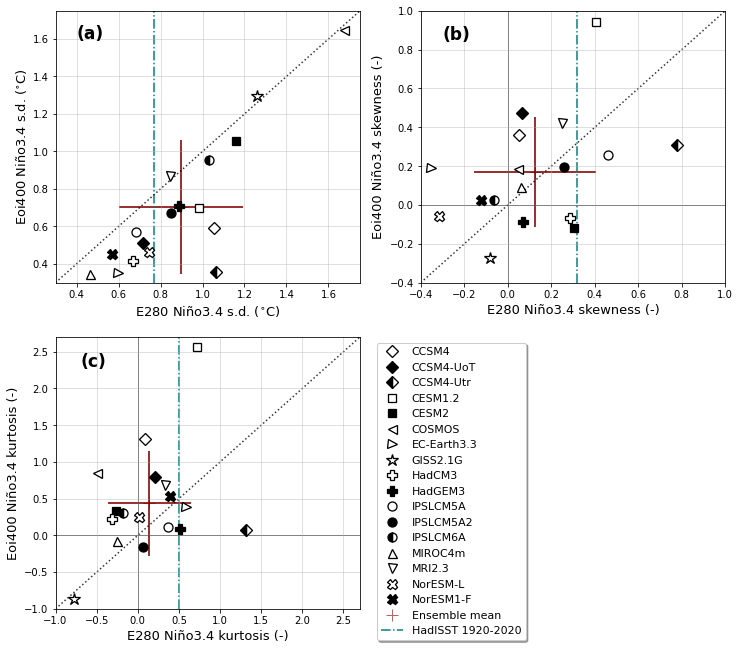

In [30]:
xlist = [std_e280,   skew_e280,   kurt_e280]
ylist = [std_eoi400, skew_eoi400, kurt_eoi400]
obs   = [np.std(nino_hadisst), skew(nino_hadisst), kurtosis(nino_hadisst)]

xlabels = [r'E280 Niño3.4 s.d. ($^{\circ}$C)',   'E280 Niño3.4 skewness (-)',   'E280 Niño3.4 kurtosis (-)']
ylabels = [r'Eoi400 Niño3.4 s.d. ($^{\circ}$C)', 'Eoi400 Niño3.4 skewness (-)', 'Eoi400 Niño3.4 kurtosis (-)']

xminlist = [0.3, -0.4, -1.0]
xmaxlist = [1.75,  1.0,  2.7]

caption = True
textx = [0.4, -0.3, -0.7]; texty = [1.6, 0.85, 2.3]; textlist = ['(a)', '(b)', '(c)'];

markers = ['D', 'D', 'D', 's', 's', '<', '>', '*', 'P', 'P', 'o', 'o', 'o', '^', 'v', 'X', 'X']
msize   = [8,    8,   8,   8,   8,   9,   9,  13,  10,   10,   9,   9,   9,   9,   9,  10,  10]
colors  = ['w', 'k', 'w', 'w', 'k', 'w', 'w', 'w', 'w', 'k', 'w', 'k', 'w', 'w', 'w', 'w', 'k']
fillstyles = ['full', 'full', 'right', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 
              'full', 'right', 'full', 'full', 'full', 'full']

fig = plt.figure(figsize=(figwidth2, 11))
gs  = gridspec.GridSpec(2, 2)

for j in range(3):
    
    i_ax = np.int(np.floor(j/2)); j_ax = np.int(np.mod(j,2))
#     ax = axs[i_ax, j_ax]
    
    ax=fig.add_subplot(gs[i_ax,j_ax])
    
    x = xlist[j]; y = ylist[j]
    xmin = xminlist[j]; xmax = xmaxlist[j]
    
    # plot model values
    for i in range(len(modellist)):
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor ='k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
#         if i<10: ax.plot(x[i], y[i], 'o', label = modellist[i], markersize = 10, markeredgecolor = 'k');
#         else:    ax.plot(x[i], y[i], 'D', label = modellist[i], markersize = 9, markeredgecolor = 'k');
            
    # plot ensemble mean +- std dev
    emcolor = 'maroon'
    ax.plot(np.mean(x), np.mean(y), color = emcolor, linestyle = 'None', marker ='+', markersize = 12, label = 'Ensemble mean', zorder=-1, alpha=0.6)    
    ax.plot([np.mean(x) - np.std(x), np.mean(x) + np.std(x)], [np.mean(y), np.mean(y)], 
        '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)
    ax.plot([np.mean(x), np.mean(x)], [np.mean(y) - np.std(y), np.mean(y) + np.std(y)], 
        '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)
    
    # plot HadISST observations
    ax.plot([obs[j], obs[j]], [xmin,xmax], color = 'teal', linestyle='-.', linewidth=1.5, alpha=1, zorder=-1, label = 'HadISST 1920-2020')
    
    # grid
    ax.grid(alpha=0.5);
    ax.plot([xmin, xmax],[xmin, xmax],'k:', alpha=0.8, zorder = -1);
    ax.plot([xmin, xmax], [0,0], 'k-', alpha=0.6, zorder=-1, linewidth=1)
    ax.plot([0,0], [xmin, xmax], 'k-', alpha=0.6, zorder=-1, linewidth=1)

    # legend
    if j==2:
        ax.legend(fontsize=legendfontsize)
        chartBox = ax.get_position()
        ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*1, chartBox.height])
        ax.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1, fontsize=11)
      
    ax.set_xlim([xmin, xmax]); ax.set_ylim([xmin, xmax])
    ax.set_xlabel(xlabels[j], fontsize=labelfontsize)
    ax.set_ylabel(ylabels[j], fontsize=labelfontsize)
    
    if caption==True:
        ax.text(textx[j], texty[j], textlist[j], fontsize = 17, fontweight = 'bold')
    
# plt.savefig('figures/std_skew_kurtosis_v2.png', bbox_inches='tight', dpi=200)
# plt.savefig('figures/std_skew_kurtosis_v4.pdf', bbox_inches='tight')
# plt.savefig('figures/figure2.pdf', bbox_inches='tight')

In [31]:
xlist = [std_e280,   skew_e280,   kurt_e280]
ylist = [std_eoi400, skew_eoi400, kurt_eoi400]
obs   = [np.std(nino_hadisst), skew(nino_hadisst), kurtosis(nino_hadisst)]

In [57]:
x = kurt_eoi400

for i in range(len(modellist)):
    print(f'{x[i]:.2f}, {modellist[i]}')
print(f'{np.mean(x):.2f}, mean')
print(f'{np.std(x):.2f}, std')

1.32, CCSM4
0.80, CCSM4-UoT
0.07, CCSM4-Utr
2.57, CESM1.2
0.33, CESM2
0.85, COSMOS
0.38, EC-Earth3.3
-0.86, GISS2.1G
0.22, HadCM3
0.09, HadGEM3
0.11, IPSLCM5A
-0.17, IPSLCM5A2
0.30, IPSLCM6A
-0.07, MIROC4m
0.68, MRI2.3
0.26, NorESM-L
0.53, NorESM1-F
0.44, mean
0.71, std


In [50]:
np.round(obs,2)

array([0.77, 0.32, 0.51])

In [53]:
 0.87 

-0.35

In [33]:
## percentual change in Nino34 standard deviation (ie 'amplitude')
perc = 100 * (std_eoi400 - std_e280) / std_e280
mean_perc = np.mean(perc)
# mean_perc = 100 * (np.mean(std_eoi400) - np.mean(std_e280)) / np.mean(std_e280);

perc_bins = [-70, -60, -50, -40, -30, -20, -10,   0,  10]
hist, bin_edges = np.histogram(perc, bins = perc_bins)

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(7,7))
for i in range(len(modellist)):
        ax.bar(modellist[i], perc[i], hatch='', color = 'royalblue')
h = plt.axhline(y = mean_perc, color = 'maroon', zorder = -1, alpha=1., linewidth=3)

ax.xaxis.tick_top(); ax.set_ylim([-70,7])
ax.tick_params(axis='x', rotation=70, labelsize=11);
ax.tick_params(axis='y', labelright=True)
ax.yaxis.grid(zorder=0); ax.set_axisbelow(True)
ax.set_ylabel('% change in Niño3.4 s.d.', size=13);
ax.legend([h], ['Ensemble mean = '+str(round(mean_perc,1))+'%'], fontsize=13);

# for i in range(len(perc_bins)-1):
#     ax.axhspan(perc_bins[i], perc_bins[i+1], facecolor = 'k', alpha = 0.1*hist[i], zorder = -1)
#     ax.text(-0.9,perc_bins[i]+1, str(hist[i]), fontsize=15)
    
# plt.savefig('Nino34StdDevChange_v4.png', bbox_inches='tight', dpi=100)
# plt.savefig('figures/nino_sd_NAC.pdf', bbox_inches='tight')

NameError: name 'std_eoi400' is not defined

In [42]:
np.mean(perc)

-23.62594710485733